# HW 2

In [1]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('diamonds_500.csv')
df.head()

,carat,cut,depth,price,x,y,z
0,1.00,Very Good,63.5,3858,6.37,6.32,4.03
1,1.02,Very Good,61.6,4291,6.46,6.47,3.98
2,1.25,Premium,62.0,8099,6.88,6.84,4.25
3,0.80,Very Good,61.9,3737,5.93,5.96,3.69
4,0.91,Good,59.9,4309,6.18,6.24,3.72


In [3]:
feature_kmeans = ['carat', 'depth', 'price']

In [32]:
def run_kmeans(data, n_clusters, n_init=10, init='random'):
    """
    data: pd.DataFrame object, dataset to run kmeans on
    n_clusters: number of clusters to run kmeans algorithm
    n_init: number of different initializations, sklearn.cluster.kmeans will return best according to initeria
    init: type of initialization, "random" for default
    
    returns: best kmeans model with specified parameter,
            cluster means for each feature,
            grand mean for each feature
    """
    data_norm = (data.values - np.mean(data.values, axis=0)) / np.std(data.values, axis=0)
    
    # Specify parameters required in the task, where 
    # n_init - Number of time the k-means algorithm will be run with different centroid seeds
    kmeans = KMeans(n_clusters=n_clusters, n_init=n_init, init=init, )
    kmeans.fit(data_norm)
    
    # Store clusters for each dataset item
    labels = kmeans.labels_
    
    cluster_means = []
    
    # Compute cluster mean for each feature
    for label in sorted(np.unique(labels)):
        cluster_means.append(np.mean(data[labels == label], axis=0))
    
    # Compute grand mean for each feature
    grand_means = np.mean(data, axis=0)
    return kmeans, np.array(cluster_means), np.array(grand_means)

In [42]:
best_kmeans_5, cluster_means_5, grand_means_5 = run_kmeans(df[feature_kmeans], n_clusters=5)
best_kmeans_9, cluster_means_9, grand_means_9 = run_kmeans(df[feature_kmeans], n_clusters=9)

In [58]:
result_5 = pd.DataFrame(100 * (cluster_means_5 - grand_means_5) / grand_means_5, columns=feature_kmeans,
                       index=[f'Cluster #{label + 1}' for label in [0, 3, 1, 2, 4]])
result_9 = pd.DataFrame(100 * (cluster_means_9 - grand_means_9) / grand_means_9, columns=feature_kmeans,
                       index=[f'Cluster #{label + 1}' for label in range(9)])

In [60]:
result_5.sort_index()

,carat,depth,price
Cluster #1,122.372182,-0.253751,262.911133
Cluster #2,4.452918,3.125289,-14.311287
Cluster #3,46.159041,-0.080906,62.383656
Cluster #4,-41.867495,0.167032,-65.823664
Cluster #5,-17.778810,-3.416819,-36.535220


In [61]:
result_9

,carat,depth,price
Cluster #1,-43.819737,-2.968760,-68.913291
Cluster #2,-38.480251,-0.340480,-62.536435
Cluster #3,29.918453,-3.757079,30.166037
Cluster #4,35.729453,0.027349,45.054750
Cluster #5,20.381719,2.480085,10.038475
Cluster #6,-45.431586,1.596148,-69.816962
Cluster #7,91.109888,0.643204,195.182556
Cluster #8,151.811458,-1.541070,280.229730
Cluster #9,-1.818546,6.116505,-34.115582


# HW 3

In [62]:
clusters = best_kmeans_5.labels_

In [63]:
df["cluster"] = clusters

In [64]:
df.head()

,carat,cut,depth,price,x,y,z,cluster
0,1.00,Very Good,63.5,3858,6.37,6.32,4.03,2
1,1.02,Very Good,61.6,4291,6.46,6.47,3.98,3
2,1.25,Premium,62.0,8099,6.88,6.84,4.25,3
3,0.80,Very Good,61.9,3737,5.93,5.96,3.69,1
4,0.91,Good,59.9,4309,6.18,6.24,3.72,4


In [65]:
price_feature = df['price'].values

In [66]:
def get_bootstrap_CI_for_mean(vector, alpha=0.95, K=5000, N=150):
    """
    vector: array to calcultat bootstrap CI for
    alpha: such that significance level 1 - alpha
    K: number of bootstrap iteration
    N: number of items for each iterations
    
    returns:
    non_pivotal_CI: tuple of left_bound and right_bound
    pivotal_CI: tuple of left_bound and right_bound
    means: vector of mean for each iteration
    """
    means = []
    # Compute bootstrap mean
    for _ in range(K):
        means.append(np.mean(np.random.choice(vector, size=N)))
    
    # Compute pivotal CI
    mean_ = np.mean(means)
    std_ = np.std(means)
    
    # Assuming Gaussian distribution of means vector
    left_boundary_pivotal = mean_ - 1.96 * std_
    right_boundary_pivotal = mean_ + 1.96 * std_
    pivotal_CI = round(left_boundary_pivotal, 2), round(right_boundary_pivotal, 2)
    
    # Take quatililes as CI borders
    left_boundary_non_pivotal = round(np.quantile(means, (1-alpha)/2),2)
    right_boundary_non_pivotal = round(np.quantile(means, (1 + alpha)/2),2)
    non_pivotal_CI = left_boundary_non_pivotal, right_boundary_non_pivotal
    
    return non_pivotal_CI, pivotal_CI, means

In [67]:
non_pivotal_CI, pivotal_CI, means_ = get_bootstrap_CI_for_mean(price_feature)

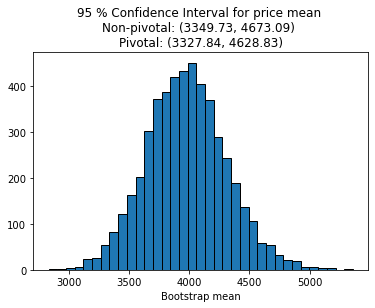

In [68]:
plt.xlabel("Bootstrap mean")
plt.title(f"95 % Confidence Interval for price mean \nNon-pivotal: {non_pivotal_CI} \nPivotal: {pivotal_CI}")
plt.hist(means_, bins=35, edgecolor='black');
plt.savefig('bootstrap_mean.png')

In [69]:
price_cluster_0 = df[df['cluster'] == 0]['price'].values
price_cluster_1 = df[df['cluster'] == 1]['price'].values

In [70]:
def get_bootstrap_CI_for_mean_diff(vector1, vector2, alpha=0.95, K=5000, N=35):
    """
    vector1: array to calcultat bootstrap CI for
    vector2: array to calcultat bootstrap CI for 
    alpha: such that significance level 1 - alpha
    K: number of bootstrap iteration
    N: number of items for each iterations
    
    returns:
    non_pivotal_CI: tuple of left_bound and right_bound
    pivotal_CI: tuple of left_bound and right_bound
    means: vector of mean for each iteration
    """
    means = []
    # Compute bootstrap mean of difference
    for _ in range(K):
        vec1 = np.random.choice(vector1, size=N)
        vec2 = np.random.choice(vector2, size=N)
        
        # get difference between two sampled vectors
        diff = np.mean(vec1) - np.mean(vec2)
        means.append(np.mean(diff))
    
    # Compute pivotal CI
    mean_ = np.mean(means)
    std_ = np.std(means)
    
    # Assuming Gaussian distribution of means vector
    left_boundary_pivotal = mean_ - 1.96 * std_
    right_boundary_pivotal = mean_ + 1.96 * std_
    pivotal_CI = round(left_boundary_pivotal, 2), round(right_boundary_pivotal, 2)
    
    # Take quatililes as CI borders
    left_boundary_non_pivotal = round(np.quantile(means, (1-alpha)/2),2)
    right_boundary_non_pivotal = round(np.quantile(means, (1 + alpha)/2),2)
    non_pivotal_CI = left_boundary_non_pivotal, right_boundary_non_pivotal
    
    return non_pivotal_CI, pivotal_CI, means

In [71]:
non_pivotal_CI, pivotal_CI, means_ = get_bootstrap_CI_for_mean_diff(price_cluster_0, price_cluster_1)

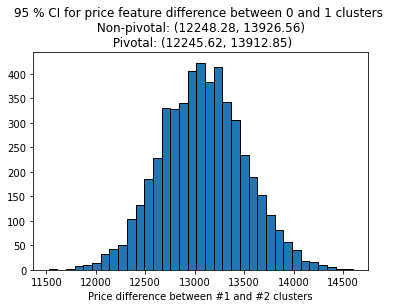

In [73]:
plt.title(f"95 % CI for price feature difference between 0 and 1 clusters \n Non-pivotal: {non_pivotal_CI} \n Pivotal: {pivotal_CI}")
plt.xlabel("Price difference between #1 and #2 clusters");
plt.hist(means_, bins=35, edgecolor='black');
plt.savefig('boot_clusters_01.png')

In [81]:
# Calculate grand mean for price feature
price_mean = np.mean(price_feature)
print(f"Grand mean of diamonds price = {round(price_mean, 2)}")

Grand mean of diamonds price = 3977.42


In [82]:
# Compute bootstrap CI for difference withing-cluster mean and grand mean
non_pivotal_CI, pivotal_CI, means_ = get_bootstrap_CI_for_mean(price_cluster_0 - price_mean)

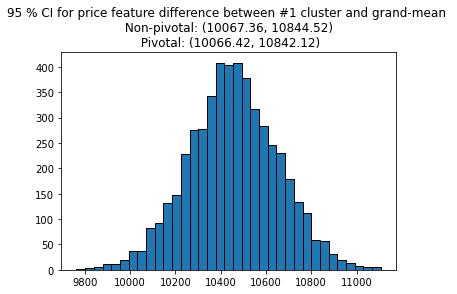

In [83]:
plt.title(f"95 % CI for price feature difference between #1 cluster and grand-mean \n Non-pivotal: {non_pivotal_CI} \n Pivotal: {pivotal_CI}")
plt.hist(means_, bins=35, edgecolor='black');
plt.savefig('boot_grandmean')